In [1]:
import networkx as nx
from itertools import product
from typing import List, Tuple, Dict
import json
import random
import sympy as sp
import numpy as np

from routing_game_utils import *

In [2]:
softmax(np.array([0, 0]))

array([0.5, 0.5])

In [3]:
def get_derivative_function(expression_str, variable='x'):    
    # define variable, parse expression
    x = sp.symbols(variable)
    expression = sp.sympify(expression_str)

    print(sp.lambdify(x, expression)(2))
    
    
    # differentiate expression w.r.t. x
    derivative_expr = sp.diff(expression, x)

    # convert derivative to python function
    derivative_func = sp.lambdify(x, derivative_expr, 'numpy')

    # print original + derivative for verifications purposes
    print(f"Original expression: {expression}")
    print(f"Derivative: {derivative_expr}")
    
    return derivative_func

In [4]:
get_derivative_function('x**2')

4
Original expression: x**2
Derivative: 2*x


<function _lambdifygenerated(x)>

In [5]:
def mixed(
    G: nx.DiGraph,
    source_sink_pairs: List[Tuple[int, int]],
    demands: List[int],
    latency_functions: Dict,
    max_iterations: int = 1000,
    learning_rate: float = .1,
    marginal_cost_pricing: bool = False,
    sensitivities: List[float] = None,
    verbose: bool = False
):
    # each player's strategy set is represented as a set of available paths from their source to their sink
    paths = get_strategy_sets(G, source_sink_pairs)
    num_players = len(source_sink_pairs)

    # start with no bias for any particular strategy
    logits = [np.array([1.0 for _ in range(len(player_path))]) for player_path in paths]

    # for each player, initialize to random strategy
    random.seed(10)
    current_flow = [random.randint(0, len(paths[player_idx]) - 1) for player_idx in range(num_players)]

    if verbose:
        print('paths ', paths)
        print('starting flow ', current_flow)
        
    iteration = 0

    # debugging information, to make sure players are picked uniformly at random
    picked_players = [0 for _ in range(num_players)]
    
    while iteration < max_iterations:
        
        if verbose:
            print('-' * 8, 'starting round: ', iteration, '-' * 8)
        iteration += 1

        # previous flows, latencies

        # TODO: can we reduce the amount of times this calculation is called so it's more efficient?
        if (marginal_cost_pricing):
            f_e, player_latencies, total_latency = calculate_edge_flows_taxed(paths, current_flow, demands, latency_functions, sensitivities)
        else:
            f_e, player_latencies, total_latency = calculate_edge_flows(paths, current_flow, demands, latency_functions)
        player_idx = random.randint(0, num_players - 1) # pick a random player
        picked_players[player_idx] += 1

        # get previous latency/path
        prev_latency = player_latencies[player_idx]
        prev_path_idx = current_flow[player_idx]
        prev_path = paths[player_idx][prev_path_idx]
        
        # construct a new flow
        mixed_strat = softmax(logits[player_idx]) # get a player's mixed strategy from their logits

        # even if we were at the best move, and we pick a worse alternative
        # what would happen is that we would evaluate the alternative to be bad, lower its probability of happening
        # then maybe go back to the best, which by virtue of being the best, we would increase its probability of happening again
        # this way, good moves get rewarded, bad moves get punished probabilistically
        alternative_path_idx = sample_move_skip_index(mixed_strat, prev_path_idx) # pick some alternate move (no point of repeating current move)
        alternative_path = paths[player_idx][alternative_path_idx]
        if sensitivities:
            s_i = sensitivities[player_idx]
        else:
            s_i = 1

        # debugging information
        if verbose:
            print('picking player', player_idx)
            print('previous latency', prev_latency)
            print('prev path idx', prev_path_idx)
            print('alternative path idx', alternative_path_idx)
            print('alternative_path')

        # develop alternative path
        hypothetical_f_e = f_e.copy()
        demand = demands[player_idx]

        # constructing the alternative flow
        # step 1: Remove player's demand from the path's edges they are currently using
        for i in range(len(prev_path) - 1):
            edge = (prev_path[i], prev_path[i + 1])
            hypothetical_f_e[edge] -= demand

        # step 2: Add player's demand to alternative path edges
        for i in range(len(alternative_path) - 1):
            edge = (alternative_path[i], alternative_path[i + 1])
            hypothetical_f_e[edge] = hypothetical_f_e.get(edge, 0) + demand

        # step 3: Compute latency for the alternative path
        alternative_latency = 0
        for i in range(len(alternative_path) - 1):
            edge = (alternative_path[i], alternative_path[i + 1])
            congestion = hypothetical_f_e[edge]
            f, f_prime = latency_functions[edge]
            if marginal_cost_pricing:
                latency = f(congestion)
                tax = congestion * f_prime(congestion)
                edge_latency =  latency + s_i * tax
            else:
                edge_latency = f(congestion)
            alternative_latency += edge_latency

        # get difference between alternative utility and current utility
        # utility is -1 * latency
        # give logit a positive increase for good delta where alternative utility increased
        delta = -alternative_latency - (-prev_latency)

        # debugging data
        if verbose:
            print('delta', delta)
            print('old logits: ', logits[player_idx])

        # update logits. positive delta = alternative was good, and should be picked more frequently in the future
        logits[player_idx][alternative_path_idx] += learning_rate * delta

        # debugging data
        if verbose:
            print('new logits: ', logits[player_idx])

        current_flow[player_idx] = alternative_path_idx

    # get final mixed strategy profile
    probabilities_profile = [softmax(player_logits) for player_logits in logits]
    print(picked_players)
    # paths: strategy sets for each player
    # current_flow: the equilibrium flow. each idx represents a player, each value represents the strategy that the player picked (ex: strategy 0, 1, ...)
    # player_latencies: the latency of each player in the equilibrium flow
    # total latency: sum of player latencies
    return paths, probabilities_profile

In [6]:
def argmax_flow(probabilities_profile):
    flow = []
    for mixed in probabilities_profile:
        flow.append(int(np.argmax(mixed)))
    return flow

In [7]:
def braess_paradox_mixed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 10000, .1, verbose=False)
    print(argmax_flow(probabilties_profile))
    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[4906, 5094]
[1, 1]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([1.77707312e-29, 1.00000000e+00, 4.35961000e-28]), array([1.45871045e-30, 1.00000000e+00, 1.19738245e-31])]


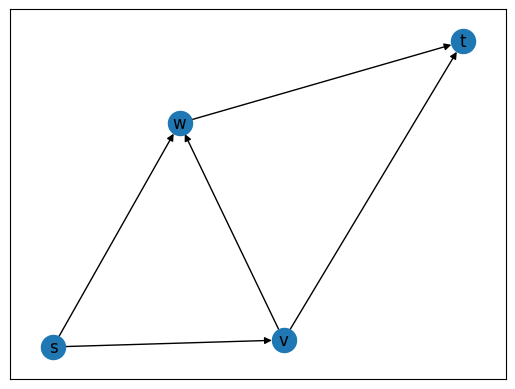

In [8]:
braess_paradox_mixed()

In [9]:
def braess_paradox_mixed_taxed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 10000, .1, marginal_cost_pricing=True, verbose=False)
    print(argmax_flow(probabilties_profile))
    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[4906, 5094]
[2, 0]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([3.99605678e-33, 4.90609473e-35, 1.00000000e+00]), array([1.00000000e+00, 7.47197234e-43, 3.03003420e-42])]


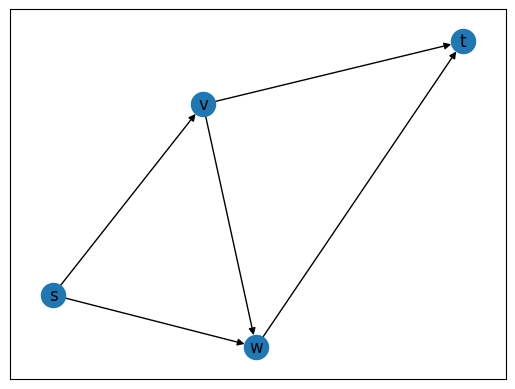

In [10]:
braess_paradox_mixed_taxed()

In [19]:
def braess_paradox_mixed_taxed_sensitivites1():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_paradox.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 10000, .1, marginal_cost_pricing=True, sensitivities=[0, 1], verbose=False)
    print(argmax_flow(probabilties_profile))
    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[4906, 5094]
[1, 0]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([2.72273599e-78, 1.00000000e+00, 4.96114844e-78]), array([9.99999996e-01, 1.15482241e-17, 3.75566675e-09])]


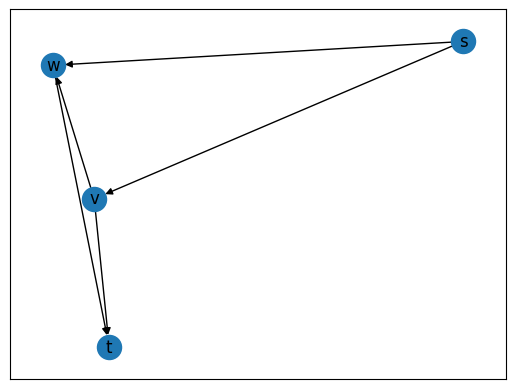

In [20]:
braess_paradox_mixed_taxed_sensitivites1()

In [11]:
def AAE_mixed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/aae_example.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 100, .1, verbose=False)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[17, 29, 24, 30]
[0, 1, 1, 0]
All paths:  [[['u', 'v'], ['u', 'w', 'v']], [['u', 'v', 'w'], ['u', 'w']], [['v', 'u', 'w'], ['v', 'w']], [['w', 'v'], ['w', 'u', 'v']]]
Probabilities profile:  [array([0.9168273, 0.0831727]), array([0.00183294, 0.99816706]), array([0.18242552, 0.81757448]), array([0.80218389, 0.19781611])]


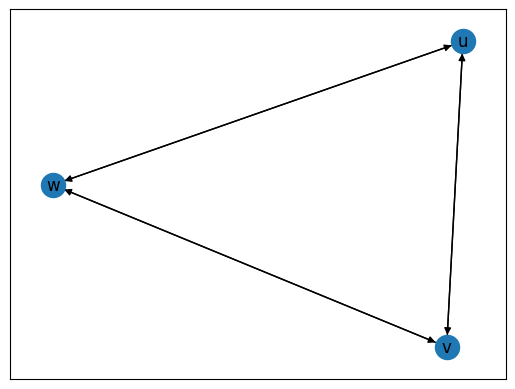

In [12]:
AAE_mixed()

In [13]:
def AAE_mixed_taxed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/aae_example.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 1000, .1, marginal_cost_pricing=True, verbose=False)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[246, 248, 233, 273]
[0, 1, 1, 0]
All paths:  [[['u', 'v'], ['u', 'w', 'v']], [['u', 'v', 'w'], ['u', 'w']], [['v', 'u', 'w'], ['v', 'w']], [['w', 'v'], ['w', 'u', 'v']]]
Probabilities profile:  [array([1.00000000e+00, 1.09187146e-34]), array([1.32673757e-32, 1.00000000e+00]), array([1.25338881e-10, 1.00000000e+00]), array([9.99999997e-01, 3.07487987e-09])]


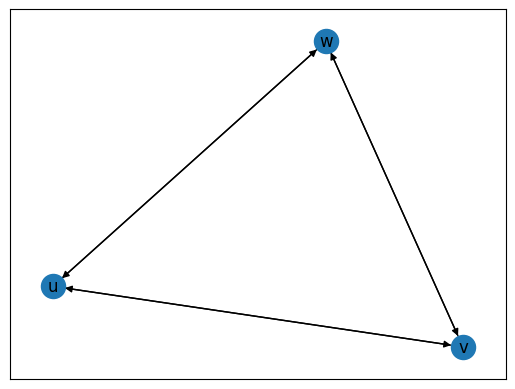

In [14]:
AAE_mixed_taxed()

In [15]:
def braess_before_mixed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/braess_before.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 100000, .1, verbose=False)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[50144, 49856]
[1, 0]
All paths:  [[['s', 'v', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([2.33154625e-18, 1.00000000e+00]), array([9.99996628e-01, 3.37200386e-06])]


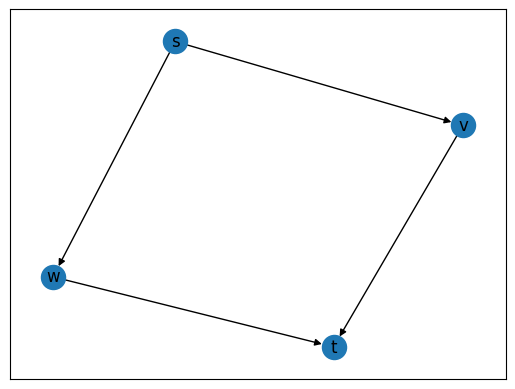

In [16]:
braess_before_mixed()

In [17]:
def no_equil_mixed():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/no_equil.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 1000, 1, verbose=False)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[494, 506]
[2, 3]
All paths:  [[['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']], [['s', 'v', 't'], ['s', 'v', 'w', 't'], ['s', 't'], ['s', 'w', 't']]]
Probabilities profile:  [array([2.04664112e-161, 1.19413680e-146, 1.00000000e+000, 5.07311613e-164]), array([6.91440011e-13, 8.75651076e-27, 2.67863696e-33, 1.00000000e+00])]


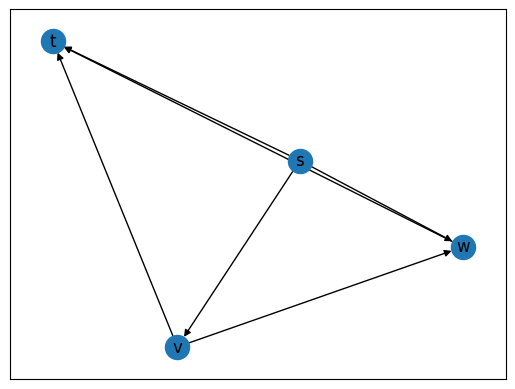

In [18]:
no_equil_mixed()

In [ ]:
def test1():
    G, source_sink_pairs, demands, latency_functions = json_to_atomic_instance('graph_examples/test1.txt')
    paths, probabilties_profile = mixed(G, source_sink_pairs, demands, latency_functions, 100, 1, marginal_cost_pricing=False, verbose=False)

    flow = argmax_flow(probabilties_profile)

    f_e, player_latencies, total_latency = calculate_edge_flows(paths, flow, demands, latency_functions)
    print(total_latency)
    print(argmax_flow(probabilties_profile))

    print('All paths: ', paths)
    print('Probabilities profile: ', probabilties_profile)

[13, 23, 18, 21, 14, 11]
184
[1, 0, 3, 1, 3, 1]
All paths:  [[['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']], [['s', 'v', 'x', 't'], ['s', 'v', 'y', 't'], ['s', 'w', 'y', 't'], ['s', 'w', 'x', 't']]]
Probabilities profile:  [array([6.79034247e-06, 9.99990819e-01, 1.67447784e-06, 7.15696831e-07]), array([9.97841242e-01, 2.12887610e-03, 5.01959607e-06, 2.48622221e-05]), array([8.07285627e-06, 2.65957672e-02, 3.80350216e-05, 9.73358125e-01]), array([3.56271353e-08, 9.99841752e-01, 7.50337033e-06, 1.50709222e-04]), array([2.14181849e-02, 2.03736077e-02, 7.89970501e-04, 9.57418237e-01]), array([1.

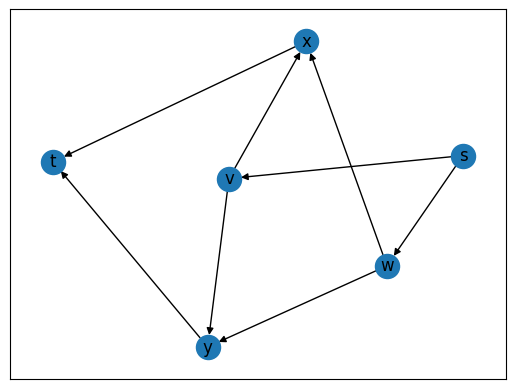

In [121]:
test1()